In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, multivariate_normal

<h1 align="center"><b><u>Lecture 6 - Markov Chain Monte Carlo (MCMC)</u></b></h1>

<h2>Probit Regression using a Gibbs Sampler</h2>

Lecture 6 gives the derivation of the Gibbs sampler that can be used to perform Probit regession.  This notebook looks as the comparison of this method, to a more traditional Maximum likelihood approach. 

A linearly separable dataset is generated simply with classes $t=0$ and $t=1$.  This is shown below.  The dataset consists of 2D vectors $\mathbf{x}^{(i)} = \begin{bmatrix}x_1^{(i)}\\x_2^{(i)}\end{bmatrix}$ and corresponding class label $t^{(i)}$.

In [2]:
# Rough number of datapoints to generate for each class
n = 50

# Uniform quadrant dataset - linearly seperable
X0 = np.array([(np.random.rand(),np.random.rand()) for _ in range(n)])
X1 = np.array([(1+np.random.rand(),1+np.random.rand()) for _ in range(n)])
t0 = np.zeros(len(X0))
t1 = np.ones(len(X1))

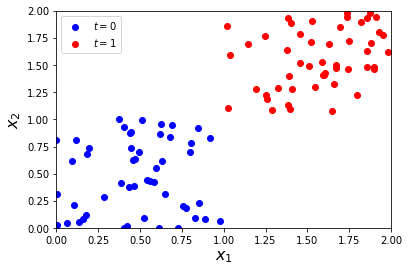

In [3]:
## Plotting
plt.scatter(X0[:,0], X0[:,1], color='b', label=r"$t=0$")
plt.scatter(X1[:,0], X1[:,1], color='r', label=r"$t=1$")
plt.legend()
plt.xlim(0,2)
plt.ylim(0,2)
plt.xlabel(r"$x_1$",fontsize=16)
plt.ylabel(r"$x_2$",fontsize=16)
plt.show()

The aim of the Probit regression, is to be able to assign a class probability to a new incoming datapoint $(\mathbf{x}^*, t^*)$ i.e. we want $p(t^* = 1 | \mathbf{x}^*, \mathbf{X}, \mathbf{t})$.

<h2>Probit Regression using Maximum Likelihood Estimation</h2>

The maximum likelihood approach is the most commonly used in this scenario.  From here on, $\mathbf{x}$ refers to an extended vector $\mathbf{x} = \begin{bmatrix}1\\x_1\\x_2\end{bmatrix}$ and $\boldsymbol{\beta} = \begin{bmatrix}\beta_0\\ \beta_1\\ \beta_2\end{bmatrix}$.


In [4]:
# Extend the input vectors
X0_tilde = np.c_[np.ones(len(X0)),X0]
X1_tilde = np.c_[np.ones(len(X1)),X1]

The model says:

$$
p(t=1| \mathbf{x}, \boldsymbol{\beta}) = \Phi(\boldsymbol{\beta}^T \mathbf{x})
$$
hence,
$$
p(t=0| \mathbf{x}, \boldsymbol{\beta}) = 1 - \Phi(\boldsymbol{\beta}^T \mathbf{x})
$$

This gives the log-likelihood:

$$
L(\boldsymbol{\beta}, \mathbf{X}, \mathbf{t}) = \sum_{i=1}^{n} \left[ t_i \log\Phi(\boldsymbol{\beta}^T \mathbf{x})  + 
(1-t_i)\log\left( 1 - \Phi(\boldsymbol{\beta}^T \mathbf{x}) \right) \right]
$$

Finding the gradient of this log-likelihood requires the relationship $\frac{\partial\Phi(x)}{\partial x} = \phi(x)$, where $\Phi$ and $\phi$ are the Gaussian cdf and pdf respectively - derive the rest yourself. Giving the gradient:

$$
\frac{\partial L}{\partial \boldsymbol{\beta}} = \sum_{i=1}^{n} 
\left[ 
\frac{t_i - \Phi(\boldsymbol{\beta}^T \mathbf{x}^{(i)})}{\Phi(\boldsymbol{\beta}^T \mathbf{x}^{(i)}) (1-\Phi(\boldsymbol{\beta}^T \mathbf{x}^{(i)}))}
\right]\phi(\boldsymbol{\beta}^T \mathbf{x}^{(i)})\mathbf{x}^{(i)}
$$



In [5]:
def grad(beta,X0,X1):
    # Find the gradient of the log-likelihood for the dataset given beta
    
    # Evaluate the gradient, given the value of t
    def grad_t(t,X):
        bx = np.dot(X,beta)
        Phi = norm.cdf(bx)
        phi = norm.pdf(bx)
        f = [ ( (t-Phi[i]) / ( Phi[i] * (1 - Phi[i]) )) * phi[i] for i in range(len(bx))]
        g = [x*f[i] for i, x in enumerate(X)]
        return sum(g)
    
    dL = 0
    dL += grad_t(0,X0)
    dL += grad_t(1,X1)

    return dL

The gradient ascent algorithm is implemented to iteratively update the weights based on the current gradient, to find the maximum of the log-likelihood. Here, $\mu$ is the learning rate and is adjusted manually for convergence to the maximum.

$$
\boldsymbol{\beta}^{(k+1)} = \boldsymbol{\beta}^{(k)} + \mu \frac{\partial L(\boldsymbol{\beta}^{(k)})}{\partial \boldsymbol{\beta}}
$$


In [6]:
def ascent(initial, steps, nu, X0, X1):
    # Performs gradient ascent algorithm
    beta = initial
    
    for _ in range(steps):
        # Get the gradient at beta
        g = grad(beta,X0,X1)
        
        # Gradient update step
        beta += nu * g

    return beta

In [7]:
initial = [1,1,1]
steps = 1000
learn_rate = 0.001

# Perform gradient ascent to find ML estimate beta
beta = ascent(initial, steps, learn_rate, X0_tilde, X1_tilde)

Now the we have a ML estimate, predictions about new inputs can be made.  Since this is a point estimate, we can say the predictive distribution is just:

$$
p(t^*=1 | \mathbf{x}^*, \boldsymbol{\beta}=\boldsymbol{\beta}_{\text{ML}}, \mathbf{X}, \mathbf{t}) = \Phi(\boldsymbol{\beta}_{\text{ML}}^T \mathbf{x}^*)
$$

In [8]:
def predict(beta,x):
    # Predicts target t, based on input x
    x = np.array([1,x[0],x[1]])
    return norm.cdf(np.dot(beta,x))

The decision boundary is the point at which the probability for either class is the same, i.e. $\boldsymbol{\beta}^T \mathbf{x} = 0$, meaning the decision boundary is orthogonal to $\boldsymbol{\beta}$.  This is shown in the plot below.

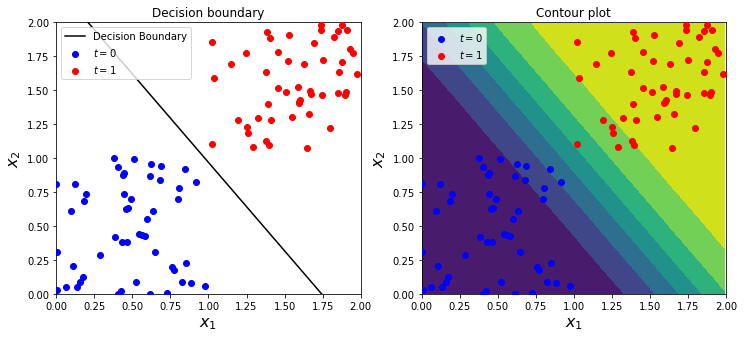

In [9]:
## Plotting
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(X0[:,0], X0[:,1], color='b', label=r"$t=0$", zorder=10)
ax1.scatter(X1[:,0], X1[:,1], color='r', label=r"$t=1$", zorder=10)
ax1.plot([0,-beta[0]/beta[1]], [-beta[0]/beta[2]  ,0], color='k', label='Decision Boundary')
# plt.contourf(x,y,Z,zorder=1)
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_xlabel(r"$x_1$",fontsize=16)
ax1.set_ylabel(r"$x_2$",fontsize=16)
ax1.legend()
ax1.set_title("Decision boundary")

N = 20
x, y = np.mgrid[-0.1:2.1:2.2/N, -0.1:2.1:2.2/N]
pos = np.dstack((x, y))

Z = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Z[i,j] = predict(beta, np.array( (x[i,j], y[i,j]) ) )

ax2.scatter(X0[:,0], X0[:,1], color='b', label=r"$t=0$", zorder=10)
ax2.scatter(X1[:,0], X1[:,1], color='r', label=r"$t=1$", zorder=10)     
ax2.contourf(x,y,Z,zorder=1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_xlabel(r"$x_1$",fontsize=16)
ax2.set_ylabel(r"$x_2$",fontsize=16)
ax2.legend()
ax2.set_title("Contour plot")

plt.show()

This has formed a reasonable decision boundary, which separates the two classes.  However, this is only a point estimate for $\boldsymbol{\beta}$ - the Gibbs sampler looks at estimating its distribution - we will see how that affects the classification later.

<h2>Probit Regression using Gibbs Sampling</h2>

As seen in the lecture slides, after the data augmentation, the full joint distribution can be split into conditionals, which are samples separately just like basic Gibbs sampler.

$$
\boldsymbol{\beta} | \mathbf{X}, \mathbf{t}, \mathbf{y} \sim \mathcal{N} (\boldsymbol{\beta}; (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \mathbf{y}, (\mathbf{X}^T\mathbf{X})^{-1} )
$$

$$
y_i | \boldsymbol{\beta}, \mathbf{X}, \mathbf{t}  \sim \textit{TN}_{(0,\infty)} (\boldsymbol{\beta}^T \mathbf{x}^{(i)}, 1)
: t_i = 1
$$

$$
y_i | \boldsymbol{\beta}, \mathbf{X}, \mathbf{t}  \sim \textit{TN}_{(\infty,0)} (\boldsymbol{\beta}^T \mathbf{x}^{(i)}, 1)
: t_i = 0
$$


In [10]:
def gibbs(initial, N, X, t):

    samples = []
    beta = initial
    
    for _ in range(N):
    
        # set up empty y vector to collect yi samples when looping over dataset
        y = []

        for i, x in enumerate(X):
            # Sample from truncated Gaussian depending on t
            if t[i] == 1:
                # This allows for easy sampling from a truncated Gaussian
                yi = 0
                while yi <= 0:
                    yi = norm.rvs(loc=np.dot(beta,x),scale=1)
            else:
                yi = 0
                while yi >= 0:
                    yi = norm.rvs(loc=np.dot(beta,x),scale=1)
            # add sample to the y vector
            y.append(yi)

        # Calculate statistics, then sample other conditional
        cov = np.linalg.inv( (X.T @ X) )              ################## From Mark's lecture notes
        mean = cov @ X.T @ np.array(y)

        beta = multivariate_normal.rvs(mean=mean, cov=cov)

        samples.append( (beta, y) )

    return samples

In [11]:
# prepare data
X = np.r_[X0_tilde, X1_tilde]
t = np.r_[t0, t1]

# Shuffle data - may only be necessary for matrix conditioning
Xt = np.c_[X,t]
np.random.shuffle(Xt)
X = Xt[:,:3]
t = Xt[:,-1]

In [12]:
# Sample beta from prior
beta = multivariate_normal.rvs(mean=[0,0,0], cov=np.eye(3))

In [13]:
# Take n samples, returning the beta and y samples
n = 500
samples = gibbs(beta, n, X, t)

beta_samples = np.array([sample[0] for sample in samples])
y_samples = np.array([sample[1] for sample in samples])

The samples of $\boldsymbol{\beta}$ can be viewed as a histogram, the maximum for each histgram found and compared to the estimate found by the Maximum likelihood algorithm.

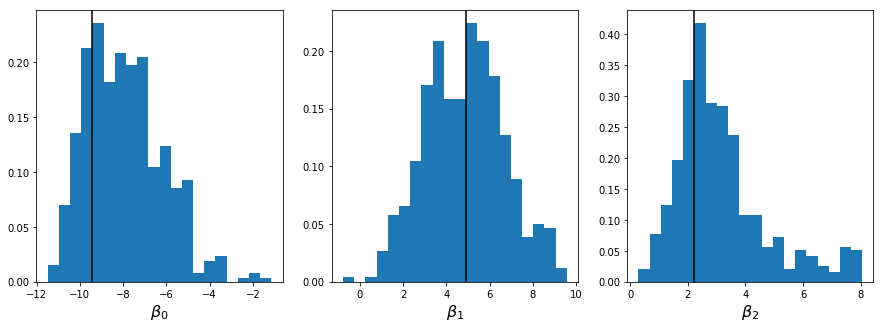

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
beta_star = np.zeros(3)
n0, b0, patches = ax[0].hist(beta_samples[:,0], 20, density="probability", histtype='stepfilled')
n1, b1, patches = ax[1].hist(beta_samples[:,1], 20, density="probability", histtype='stepfilled')
n2, b2, patches = ax[2].hist(beta_samples[:,2], 20, density="probability", histtype='stepfilled')
beta_star[0] = b0[np.where(n0 == n0.max())]
beta_star[1] = b1[np.where(n1 == n1.max())]
beta_star[2] = b2[np.where(n2 == n2.max())]
ax[0].axvline(beta_star[0],color='k')
ax[1].axvline(beta_star[1],color='k')
ax[2].axvline(beta_star[2],color='k')
ax[0].set_xlabel(r"$\beta_0$",fontsize=16)
ax[1].set_xlabel(r"$\beta_1$",fontsize=16)
ax[2].set_xlabel(r"$\beta_2$",fontsize=16)
plt.show()

The distribution of the weight parameters are neither very linear nor tight around the maximum, suggesting the point estimate may not be an accurate representation of the posterior predictive distribution.

In this case, now we are looking a a $\boldsymbol{\beta}$ with a distribution, the prediction changes.  The parameters are maginalised out to find the prediction as shown below, with $\mathcal{D} = \{ \mathbf{X}, \mathbf{t} \}$:

$$
p(t^* = 1| \mathbf{x}^*, \mathcal{D}) = \int p(t^* = 1| \mathbf{x}^*, \boldsymbol{\beta}, \mathcal{D}) p(\boldsymbol{\beta}|\mathcal{D}) d\boldsymbol{\beta}
$$

In this case, we have generated samples from $p(\boldsymbol{\beta}|\mathcal{D})$ during the Gibbs procedure.  Looking back to the first two lectures, this integral can be approximated using Monte Carlo, when rewritten as an expectation.

Since 

$$
p(t^* = 1| \mathbf{x}^*, \boldsymbol{\beta}, \mathcal{D}) = \Phi(\boldsymbol{\beta}^T \mathbf{x}^*)
$$

we can write:

$$
\int p(t^* = 1| \mathbf{x}^*, \boldsymbol{\beta}, \mathcal{D}) p(\boldsymbol{\beta}|\mathcal{D}) d\boldsymbol{\beta} = 
\mathbb{E}_{p(\boldsymbol{\beta}|\mathcal{D})} \{ \Phi(\boldsymbol{\beta}^T \mathbf{x}^*)  \}
$$

and 

$$
\mathbb{E}_{p(\boldsymbol{\beta}|\mathcal{D})} \{ \Phi(\boldsymbol{\beta}^{T} \mathbf{x}^*)  \}
\approx \frac{1}{n} \sum_{i-1}^{n} \Phi(\boldsymbol{\beta}^{(i)T} \mathbf{x}^*)
$$

This can be used to find improved predictive probabilities over the space, and is demonstrated below by evaluating the above expression on a grid over the input space to give a contour plot.

In [15]:
def predict_gibbs(beta_samples, x):
    x = np.array([1,x[0],x[1]])
    f = [norm.cdf(np.dot(beta,x)) for beta in beta_samples]
    return sum(f)/len(beta_samples)

In [16]:
N = 20
x, y = np.mgrid[-0.1:2.1:2.2/N, -0.1:2.1:2.2/N]
pos = np.dstack((x, y))

Z = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Z[i,j] = predict_gibbs(beta_samples, np.array( (x[i,j], y[i,j]) ) )

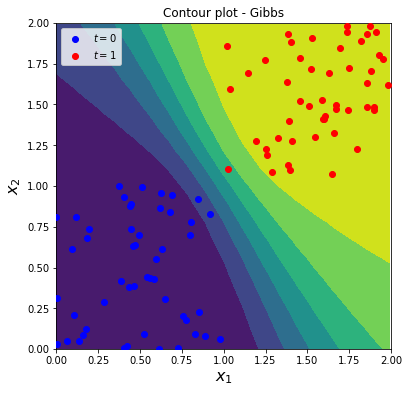

In [17]:
fig, axs = plt.subplots(1,figsize=(6,6))
plt.scatter(X0[:,0], X0[:,1], color='b', label=r"$t=0$", zorder=10)
plt.scatter(X1[:,0], X1[:,1], color='r', label=r"$t=1$", zorder=10)
plt.contourf(x,y,Z,zorder=1)
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend()
plt.xlabel(r"$x_1$",fontsize=16)
plt.ylabel(r"$x_2$",fontsize=16)
plt.title("Contour plot - Gibbs")
plt.show()

The above plot shows the nonlinear boundary, which is a result of the distribution over $\boldsymbol{\beta}$ being included.  There is a practical balance to the improvement in predicitve probability, which is the significant increase in computation time and memory required, since all the samples must be stored in order to evaluate the predictive probability.  Bayesian logistic regression, interestingly,  approximates the distribution over weights with a Gaussian, making the predictive distribution analytically tractable - some of you may have come accross this in the 3F8 FTR.